In [90]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define the constants

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3
INPUT_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
EPOCHS = 35
POOL_SIZE = 2

# https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2
# 0.0005, 0.001, 0.00146 
LR = 0.001


In [3]:
# Part 1 - Preparing data
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical 
train_datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2)


test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/jj/dataset_passport_aadhar/training_set/',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=42)

testing_set = test_datagen.flow_from_directory('/content/drive/MyDrive/jj/dataset_passport_aadhar/testing_set/',
                                            target_size = (128, 128),
                                            batch_size = 1,
                                            shuffle=False,
                                            class_mode = 'categorical')

nb_training_samples=len(training_set.filenames)
print(nb_training_samples)
num_classes=len(training_set.class_indices)
print(num_classes,"train num class")

nb_testing_samples=len(testing_set.filenames)
print(nb_testing_samples,"testing num_class")
num_classes=len(testing_set.class_indices)
print(num_classes,"Test num classes")

Found 167 images belonging to 3 classes.
Found 71 images belonging to 3 classes.
167
3 train num class
71 testing num_class
3 Test num classes


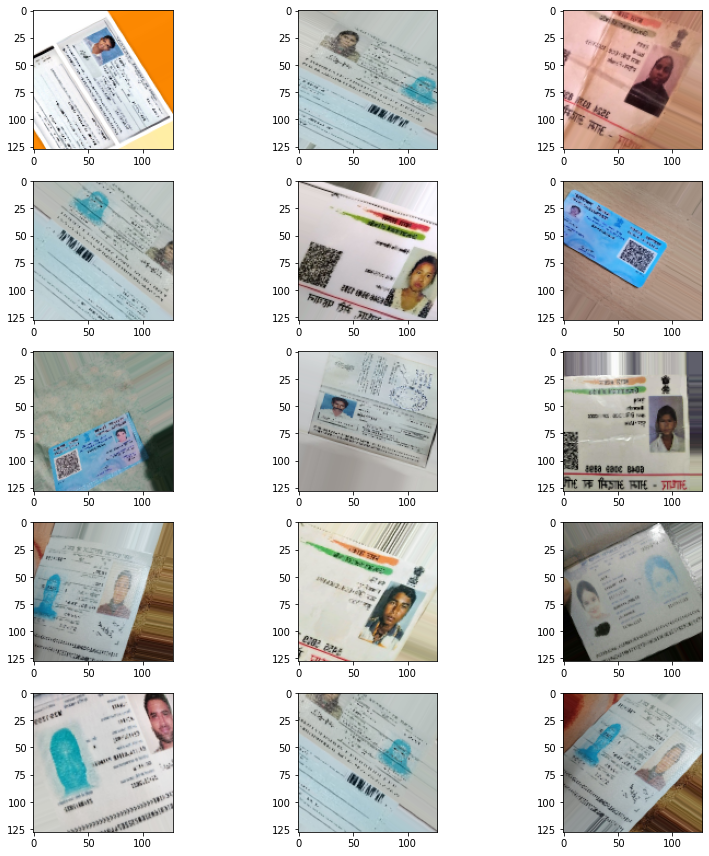

In [94]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# print 15 sample training image
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in training_set:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [4]:
# # Part 2 - Building the CNN
# # Importing the Keras libraries and packages
import time

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Use EarlyStopping and ReduceLROnPlateau
# when train, it keep testing set separetely and if the error is not improve for 5 times, training stop
# earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

# Save the best weight for epoch checkpoint
checkpointer = ModelCheckpoint(filepath = "best_weight.hdf5", monitor='val_loss', verbose=0, save_best_only=True) 


In [13]:
from keras.optimizers import Adam

print("Start training...")

STEP_SIZE_TRAIN = training_set.n//training_set.batch_size
STEP_SIZE_TEST = testing_set.n//testing_set.batch_size

# CONV_LAYERS = [1, 2, 3]
# LAYER_SIZES = [32, 64, 128]
# DENSE_LAYERS = [0, 1, 2]

CONV_LAYERS = [2]
LAYER_SIZES = [64]
DENSE_LAYERS = [2]

# Hyper-parameter tuning. Trial and Error
# Set Optimizer. Adam or RMSprop
# https://datascience.stackexchange.com/questions/43191/validation-loss-is-not-decreasing
opt = Adam(lr=LR, decay=1e-6)

for dense_layer in DENSE_LAYERS:
    for layer_size in LAYER_SIZES:
        for conv_layer in CONV_LAYERS:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()
            
            # input layer 
            model.add(Conv2D(layer_size, (3, 3), input_shape = INPUT_SHAPE, activation = 'relu'))
            model.add(MaxPooling2D(pool_size = (POOL_SIZE, POOL_SIZE)))

            # hidden layer
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))
            
            # output layer
            model.add(Dense(num_classes))
            model.add(Activation('softmax'))

            callbacks = [checkpointer]

            model.compile(loss='categorical_crossentropy',
                          optimizer=opt,
                          metrics=['acc'])
            
            model.summary()
            
            history = model.fit_generator(training_set, 
                                epochs = EPOCHS, 
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data = testing_set,
                                validation_steps=STEP_SIZE_TEST,
                                callbacks=callbacks)

Start training...
2-conv-64-nodes-2-dense-1670696917
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 activation_4 (Activation)   (None, 61, 61, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-13-102b2f9cde64>:57: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_set,


Epoch 1/35
5/5 [==============================] - 12s 3s/step - loss: 1.4820 - acc: 0.4519 - val_loss: 1.0220 - val_acc: 0.4225
Epoch 2/35
5/5 [==============================] - 19s 4s/step - loss: 1.0402 - acc: 0.4296 - val_loss: 0.9657 - val_acc: 0.4789
Epoch 3/35
5/5 [==============================] - 12s 3s/step - loss: 0.9793 - acc: 0.4000 - val_loss: 0.9273 - val_acc: 0.4225
Epoch 4/35
5/5 [==============================] - 11s 2s/step - loss: 0.9363 - acc: 0.5037 - val_loss: 0.8173 - val_acc: 0.6761
Epoch 5/35
5/5 [==============================] - 11s 2s/step - loss: 0.9779 - acc: 0.4222 - val_loss: 0.7395 - val_acc: 0.6620
Epoch 6/35
5/5 [==============================] - 11s 2s/step - loss: 0.8732 - acc: 0.5926 - val_loss: 0.7870 - val_acc: 0.5211
Epoch 7/35
5/5 [==============================] - 11s 2s/step - loss: 0.8135 - acc: 0.6741 - val_loss: 0.5820 - val_acc: 0.8451
Epoch 8/35
5/5 [==============================] - 11s 3s/step - loss: 0.8695 - acc: 0.5778 - val_loss: 0

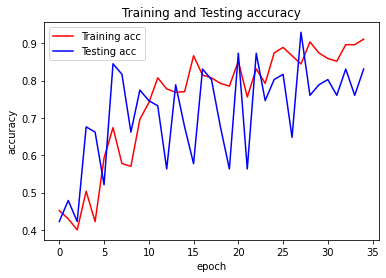

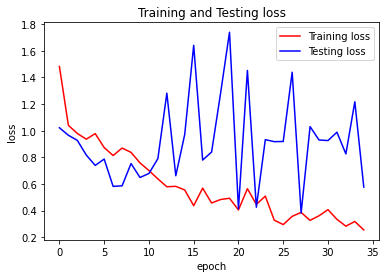

In [14]:
# plot history
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Testing acc')
plt.title('Training and Testing accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [15]:
print(model.metrics_names)
model.evaluate(testing_set)

['loss', 'acc']
71/71 [==============================] - 5s 68ms/step - loss: 0.5766 - acc: 0.8310


[0.5766433477401733, 0.8309859037399292]

In [16]:
training_set.class_indices

{'aadhar': 0, 'passport': 1, 'rejected': 2}

In [17]:
import numpy as np
predictions=model.predict_generator(testing_set,steps=STEP_SIZE_TEST)
predicted_classes = np.argmax(predictions, axis=1)
true_class=testing_set.classes
class_labels = list(testing_set.class_indices.keys())   

<ipython-input-17-93970490a4a6>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=model.predict_generator(testing_set,steps=STEP_SIZE_TEST)


71/71 [==============================] - 4s 51ms/step
Confusion Matrix


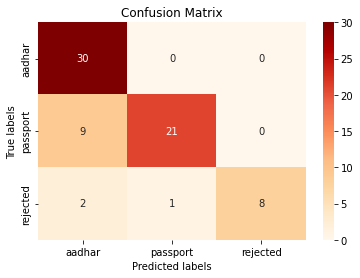

In [18]:
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

labels = testing_set.class_indices

Y_pred = model.predict(testing_set, testing_set.n // testing_set.batch_size)

print('Confusion Matrix')
cm = confusion_matrix(true_class, predicted_classes)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='OrRd'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [19]:
print('Classification Report')
print(classification_report(true_class,predicted_classes,target_names=class_labels))

Classification Report
              precision    recall  f1-score   support

      aadhar       0.73      1.00      0.85        30
    passport       0.95      0.70      0.81        30
    rejected       1.00      0.73      0.84        11

    accuracy                           0.83        71
   macro avg       0.90      0.81      0.83        71
weighted avg       0.87      0.83      0.83        71



Please enter the image path/content/drive/MyDrive/jj/dataset_passport_aadhar/training_set/rejected/194bcd0909e49b193fce19650e1c64de.jpg
1/1 [==============================] - 0s 30ms/step
ID: 2, Label: rejected
Rejected


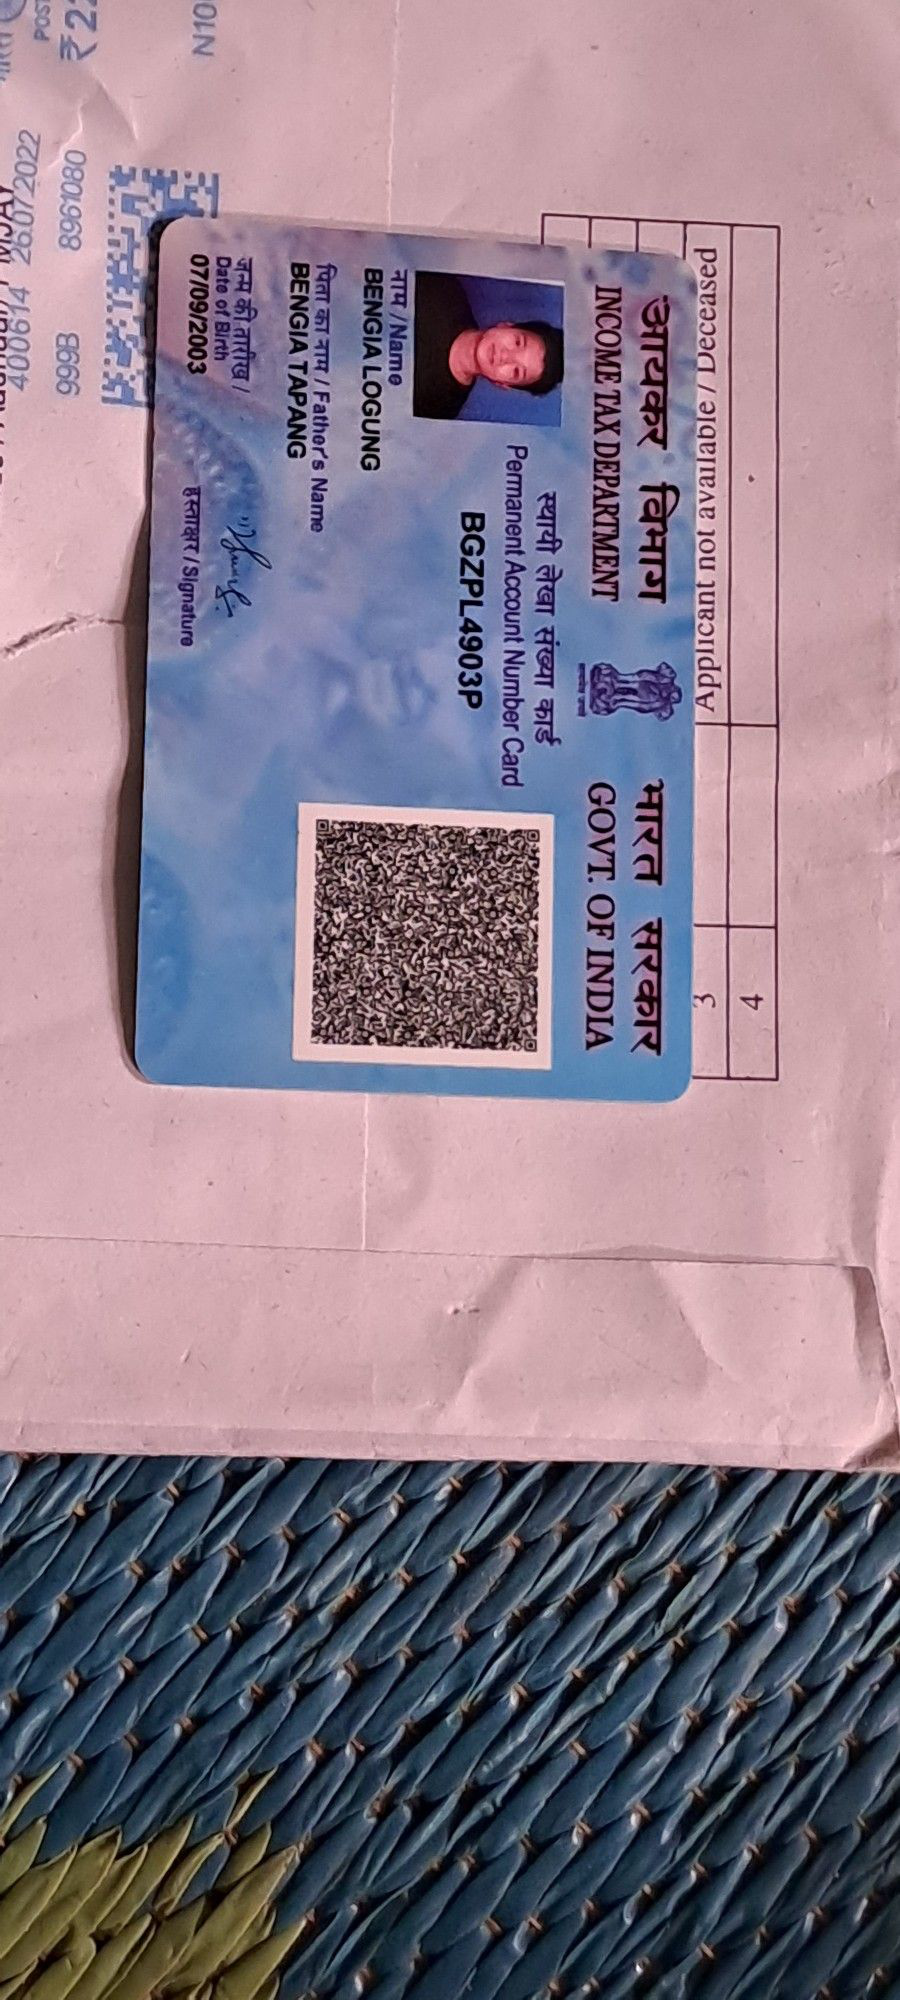

In [38]:
from keras_preprocessing.image import ImageDataGenerator, img_to_array, load_img 
import numpy as np
from keras.models import load_model

model.save('model.h5') 
def read_image(file_path):
   image = load_img(file_path, target_size=(128, 128)) 
   image = img_to_array(image) 
   image = np.expand_dims(image, axis=0)
   image /= 255. 
   return image
  
def test_single_image(path):
      classes=["aadhar","passport","rejected"]
      images = read_image(path)
      time.sleep(.5)
      bt_prediction = model.predict(images) 
      threshold = 0.5  # You may need to experiment with different values
      # Loop over the predicted probabilities for each image
    
      # print("Accepted")
      class_predicted = np.argmax(bt_prediction,axis=1)
      class_dictionary = training_set.class_indices 
      inv_map = {v: k for k, v in class_dictionary.items()} 
      print("ID: {}, Label: {}".format(class_predicted[0],  inv_map[class_predicted[0]])) 
      for i in range(len(bt_prediction)):
      # If the predicted probability of the image belonging to the
      # "rejection" class is higher than the threshold, reject the image
        if bt_prediction[i][2] > threshold:
          bt_prediction[i] = -1  # Set the predicted label to -1 to indicate rejection
          print("Rejected")
        else:
          print("Accepted")
      return load_img(path)
path = str(input("Please enter the image path"))
test_single_image(path)